# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid') # Nice background styling on plots

In [2]:
#Your code here
web_df = pd.read_csv("homepage_actions.csv")
web_df

,timestamp,id,group,action
0,42:27.8,804196,experiment,view
1,19:03.5,434745,experiment,view
2,36:00.9,507599,experiment,view
3,59:02.6,671993,control,view
4,26:14.5,536734,experiment,view
...,...,...,...,...
8183,11:42.0,192060,experiment,view
8184,42:12.8,755912,experiment,view
8185,01:09.0,458115,experiment,view
8186,08:51.6,505451,control,view


In [3]:
# Check for duplicates
num_duplicates = len(web_df[web_df.duplicated()])
print("Number of duplicates =", num_duplicates)

Number of duplicates = 0


In [4]:
# Check whether there is an overlap between the control and experiment group
num_overlap = len(web_df[web_df.duplicated(['id']) & 
                         ~(web_df.duplicated(['group']))])
print("Number of overlapping entries =", num_overlap)

Number of overlapping entries = 0


In [5]:
# Check whether there is anyone who clicked without viewing
num_duplicate_ids_with_double_clicks = len(web_df[web_df.duplicated(['id']) & 
                                                  (web_df['action'].nunique() == 1)])
num_unique_ids_with_no_view = len((web_df[~(web_df.duplicated(['id'])) & 
                                          (web_df['action'] == 'click')]))
print("Number of people who clicked but didn't view =", 
      num_duplicate_ids_with_double_clicks + num_unique_ids_with_no_view)

Number of people who clicked but didn't view = 0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

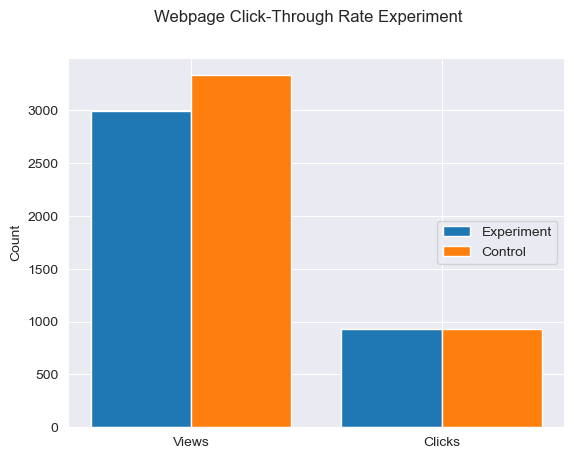

In [6]:
# Plot bar graphs of views and clicks for control and experiment groups
fig, ax = plt.subplots()

# Calculate the counts of views and clicks
experiment_count_of_clicks = len(web_df.loc[(web_df['group'] == 'experiment') & 
                                            (web_df['action'] == 'click')])
experiment_count_of_views = len(web_df.loc[(web_df['group'] == 'experiment') & 
                                            (web_df['action'] == 'view')])

control_count_of_clicks = len(web_df.loc[(web_df['group'] == 'control') & 
                                            (web_df['action'] == 'click')])
control_count_of_views = len(web_df.loc[(web_df['group'] == 'control') & 
                                            (web_df['action'] == 'view')])


# Placeholder data for display purposes
x = np.array([0, 5])
offset = 1
bar_width = 2

# Plot bars
ax.bar(x-offset, [experiment_count_of_views, experiment_count_of_clicks], 
       bar_width, label="Experiment")
ax.bar(x+offset, [control_count_of_views, control_count_of_clicks], 
       bar_width, label="Control")

# Customize appearance
ax.set_xticks(x)
ax.set_xticklabels(["Views", "Clicks"])
ax.set_ylabel("Count")
ax.legend(loc="right")
fig.suptitle("Webpage Click-Through Rate Experiment");

In [7]:
# Determine click-through rates
# Given that there were no clicks without views,
# Click-through rate = number of clicks/number of views

experiment_count_of_clicks = len(web_df.loc[(web_df['group'] == 'experiment') & 
                                            (web_df['action'] == 'click')])
experiment_count_of_views = len(web_df.loc[(web_df['group'] == 'experiment') & 
                                            (web_df['action'] == 'view')])
experiment_click_through_rate = experiment_count_of_clicks / experiment_count_of_views

control_count_of_clicks = len(web_df.loc[(web_df['group'] == 'control') & 
                                            (web_df['action'] == 'click')])
control_count_of_views = len(web_df.loc[(web_df['group'] == 'control') & 
                                            (web_df['action'] == 'view')])
control_click_through_rate = control_count_of_clicks / control_count_of_views

print("Experimental Click-Through Rate =", experiment_click_through_rate)
print("Control Click-Through Rate =", control_click_through_rate)

Experimental Click-Through Rate = 0.3097463284379172
Control Click-Through Rate = 0.2797118847539016


In [8]:
print(""" 
Hypothesis formulation:
Null Hypothesis (H0) : The click-through rate of the experimental homepage is higher than that of the control group.

Alternative Hypothesis (Ha) : The click-through rate of the experimental homepage is not higher than that of the control group.
""")

 
Hypothesis formulation:
Null Hypothesis (H0) : The click-through rate of the experimental homepage is higher than that of the control group.

Alternative Hypothesis (Ha) : The click-through rate of the experimental homepage is not higher than that of the control group.



In [9]:
# Perform a Chi-square test for goodness of fit
experiment_result = stats.chisquare([experiment_count_of_views, experiment_count_of_clicks], 
                                    [control_count_of_views, control_count_of_clicks])
experiment_result

Power_divergenceResult(statistic=33.89952032315072, pvalue=5.8033006040559e-09)

In [10]:
print(""" The pvalue for one-tail test is about 5.8033006040559e-09, which is much less than an experimental 
significance level of alpha=0.05.
Therefore, I reject the null hypothesis and conclude that the experimental homepage
performed better that of the control group. 
""")

 The pvalue for one-tail test is about 5.8033006040559e-09, which is much less than an experimental 
significance level of alpha=0.05.
Therefore, I reject the null hypothesis and conclude that the experimental homepage
performed better that of the control group. 



## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [11]:
# For each unqique id, replace a click with one and a no click with zero
web_df['action'] = web_df['action'].replace(['view', 'click'], [0,1])

# Compute the click-through rate of the control group
num_control_clicks = len(web_df[(web_df['group'] == 'control') & (web_df['action'] == 1)])
num_control_views = len(web_df[(web_df['group'] == 'control') & (web_df['action'] == 0)])
control_click_through_rate = num_control_clicks / num_control_views

# Compute the expected count of clicks
num_experimental_views = len(web_df[(web_df['group'] == 'experiment') & 
                                    (web_df['action'] == 0)])
num_expected_clicks = num_experimental_views * control_click_through_rate

# Print the result
print('Number of Expected Clicks =', int(num_expected_clicks))

Number of Expected Clicks = 838


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [12]:
# Z-score = (actual value - expected value) / (standard deviation/sqrt(sample size))
# standard deviation = sqrt(variance)
p = control_click_through_rate
n = len(web_df[(web_df['group'] == 'experiment')])
variance = n * p * (1-p)
sigma = sqrt(variance)

num_experimental_clicks = len(web_df[(web_df['group'] == 'experiment') & 
                                     (web_df['action'] == 1)])

z_score = (num_experimental_clicks - num_expected_clicks) / sigma
print('Number of Standard Deviations =', z_score)

Number of Standard Deviations = 3.200282505769741


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [13]:
# P-value for a normal distribution
p_value = 1 - stats.norm.cdf(z_score)
p_value

0.0006864647235972354

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Your analysis here**

<font color='blue'>Yes, while the p-value is higher than in the previous Chi-square test, but both would lead to 
confident rejection of the null hypothesis. The experimental homepage has a significantly better performance than 
that of the control group.<font>

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.